##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [2]:
!pip install -q tensorflow==2.1.0

Install TensorFlow Quantum:

In [3]:
!pip install -q tensorflow-quantum

Now import TensorFlow and the module dependencies:

In [654]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import tensorflow_quantum as tfq


import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Circ circuits to TensorFlow Quantum circuits. 

In [120]:
import itertools
num_bits = 3

x_train = []
y_train = []

for comb in itertools.product('01', repeat=num_bits):
    comb = [int(x) for x in comb]
    x_train.append(comb)
    y_train.append(sum(comb) % 2)
#     y_train.append(int(comb[0]))
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [121]:
def convert_to_circuit(values):
    """Encode truncated classical image into quantum datapoint."""
#     values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(num_bits, 1) 
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train]

In [122]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)

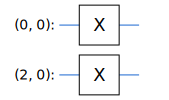

In [130]:
SVGCircuit(x_train_circ[5])

In [124]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
#             circuit.append(gate(qubit, self.readout))

Build an example circuit layer to see how it looks:

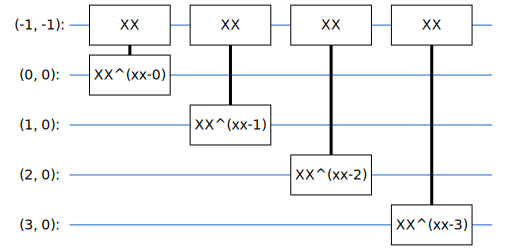

In [125]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [126]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(num_bits, 1)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
#     circuit.append(cirq.H(readout))
#     symbol = sympy.Symbol('tmp')
#     circuit.append(cirq.X(readout)**symbol)
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.CX, "xx1")
#     circuit.append(cirq.CX())
#     builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
#     circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [127]:
model_circuit, model_readout = create_quantum_model()

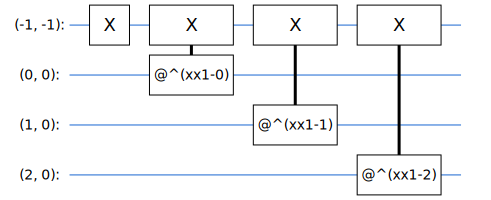

In [128]:
SVGCircuit(model_circuit)

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [129]:

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(num_bits, 1)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
#     circuit.append(cirq.H(readout))
#     symbol = sympy.Symbol('tmp')
#     circuit.append(cirq.X(readout)**symbol)
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.CX, "xx1")
#     circuit.append(cirq.CX())
#     builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
#     circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

# Build the Keras model.

model_circuit, model_readout = create_quantum_model()
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train-1.0
# y_test_hinge = 2.0*y_test-1.0

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(1e-2),
    metrics=[hinge_accuracy])

EPOCHS = 100
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1)

# qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 8 samples
Epoch 1/100
8/8 [==============================] - 1s 135ms/sample - loss: 0.9998 - hinge_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 902us/sample - loss: 0.9992 - hinge_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 0s 485us/sample - loss: 0.9981 - hinge_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 439us/sample - loss: 0.9966 - hinge_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 0s 472us/sample - loss: 0.9947 - hinge_accuracy: 0.5000
Epoch 6/100
8/8 [==============================] - 0s 536us/sample - loss: 0.9923 - hinge_accuracy: 0.5000
Epoch 7/100
8/8 [==============================] - 0s 626us/sample - loss: 0.9894 - hinge_accuracy: 0.5000
Epoch 8/100
8/8 [==============================] - 0s 686us/sample - loss: 0.9860 - hinge_accuracy: 0.5000
Epoch 9/100
8/8 [==============================] - 0s 594us/sample - loss: 0.9820 - hinge_accuracy: 0.5000
Epoch 10/100
8/8 [

Epoch 77/100
8/8 [==============================] - 0s 557us/sample - loss: 0.0366 - hinge_accuracy: 1.0000
Epoch 78/100
8/8 [==============================] - 0s 512us/sample - loss: 0.0321 - hinge_accuracy: 1.0000
Epoch 79/100
8/8 [==============================] - 0s 513us/sample - loss: 0.0280 - hinge_accuracy: 1.0000
Epoch 80/100
8/8 [==============================] - 0s 532us/sample - loss: 0.0242 - hinge_accuracy: 1.0000
Epoch 81/100
8/8 [==============================] - 0s 524us/sample - loss: 0.0209 - hinge_accuracy: 1.0000
Epoch 82/100
8/8 [==============================] - 0s 553us/sample - loss: 0.0179 - hinge_accuracy: 1.0000
Epoch 83/100
8/8 [==============================] - 0s 522us/sample - loss: 0.0153 - hinge_accuracy: 1.0000
Epoch 84/100
8/8 [==============================] - 0s 547us/sample - loss: 0.0130 - hinge_accuracy: 1.0000
Epoch 85/100
8/8 [==============================] - 0s 466us/sample - loss: 0.0109 - hinge_accuracy: 1.0000
Epoch 86/100
8/8 [==========

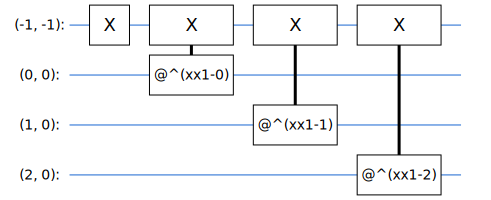

In [637]:
SVGCircuit(model_circuit)

In [638]:
model.layers[-1].get_weights()

[array([3.0059004, 3.9939032, 2.0032835], dtype=float32)]

# QRAC

In [80]:
def convert_to_angle(b_st):
    if b_st[0] == 1:
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == 1 and b_st[2] == 1:
        varphi = np.pi / 4

    if b_st[1] == 1 and b_st[2] == 0:
        varphi = 3 * np.pi / 4

    if b_st[1] == 0 and b_st[2] == 0:
        varphi = -3 * np.pi / 4

    if b_st[1] == 0 and b_st[2] == 1:
        varphi = -np.pi / 4
            
    return [theta, varphi]

def convert_backward_to_angle(b_st):
    if b_st[2] == 1:
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[0] == 1 and b_st[1] == 1:
        varphi = np.pi / 4

    if b_st[0] == 1 and b_st[1] == 0:
        varphi = 3 * np.pi / 4

    if b_st[0] == 0 and b_st[1] == 0:
        varphi = -3 * np.pi / 4

    if b_st[0] == 0 and b_st[1] == 1:
        bvarphi = -np.pi / 4
            
    return [theta, varphi]

def encode_31(data):
    
    var_list = []
    for i in range(0, len(data)-2, 1):
        var_list += convert_to_angle(data[i:i+3])
        var_list += convert_to_angle(data[i:i+3])
        var_list += convert_to_angle(data[i:i+3])
#         var_list += convert_backward_to_angle(data[i:i+3])
#         var_list += convert_to_angle([data[i+2],data[i],data[i+1]])
#         var_list += convert_to_angle([data[i+1],data[i+2],data[i]])
        
    return var_list


data_train = [encode_31(x) for x in x_train]
        
    
    

In [96]:
# 3-2 Encoding

import math
def ch(qProg, a, b):
    """ Controlled-Hadamard gate """
    qProg.h(b)
    qProg.sdg(b)
    qProg.cx(a, b)
    qProg.h(b)
    qProg.t(b)
    qProg.cx(a, b)
    qProg.t(b)
    qProg.h(b)
    qProg.s(b)
    qProg.x(b)
    qProg.s(a)
    return qProg

def encoding000(qProg, a, b):
    return qProg

def encoding011(qProg, a, b):
    qProg.x(b)
    return qProg

def encoding101(qProg, a, b):
    qProg.x(a)
    return qProg
    
def encoding110(qProg, a, b):
    qProg.x(a)
    qProg.x(b)
    return qProg

p = 1.0/2.0 + np.sqrt(6.0)/6.0 
theta1 = 2.0*math.acos(np.sqrt(1.0/3.0))
theta2 = 2.0*math.acos(np.sqrt(2.0/3.0))

lambda1 = 2.0*math.acos(np.sqrt(p))
lambda2 = 2.0*math.acos(np.sqrt(1.0-p))


def encoding001(qProg, a, b):
    qProg.u3(theta2, 0, 0, a)
    qProg.x(a)
    qProg = ch(qProg, a, b)
    qProg.x(a)
    return qProg
    
def encoding010(qProg, a, b):
    qProg.u3(theta2, 0, 0, a)
    qProg.x(b)
    qProg.x(a)
    qProg = ch(qProg, a, b)
    qProg.x(a)
    return qProg

def encoding100(qProg, a, b):
    qProg.u3(theta1, 0, 0, a)
    qProg = ch(qProg, a, b)
    qProg.x(a)
    qProg.x(b)
    qProg.cz(a, b)
    qProg.x(a)
    qProg.x(b)
    return qProg

def encoding111(qProg, a, b):
    qProg.u3(theta1, 0, 0, a)
    qProg.x(b)
    qProg = ch(qProg, a, b)
    qProg.cx(a, b)
    return qProg

encodingFunctions = {
    "000": encoding000,
    "001": encoding001,
    "010": encoding010,
    "011": encoding011,
    "100": encoding100,
    "101": encoding101,
    "110": encoding110,
    "111": encoding111
}

from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

states = []

for data in x_train:

    sv = Statevector.from_label('0000')

    mycircuit = QuantumCircuit(4)
    mycircuit = encodingFunctions[''.join(data.astype(str))](mycircuit, 1, 2)
#     mycircuit = encodingFunctions[''.join(data.astype(str))](mycircuit, 3, 4)
#     mycircuit.draw('mpl')

    new_sv = sv.evolve(mycircuit)
    states.append(new_sv.data)
    
states = np.array(states)



In [97]:
num_state = states.shape[-1]

W = tf.Variable(np.random.random((num_state,num_state)) + np.random.random((num_state,num_state)) * 1j)

EPOCHS = 10000
lamb = 0

opt = tf.keras.optimizers.Adam(1e-1)

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

y_train_hinge = 2.0*y_train-1.0

for i in range(EPOCHS):
    with tf.GradientTape() as g:
        reg1 = tf.reduce_sum((tf.eye(num_state, dtype=tf.complex128) - tf.matmul(W, tf.transpose(W, conjugate=True))) ** 2)
        reg2 = tf.reduce_sum((tf.eye(num_state, dtype=tf.complex128) - tf.matmul(tf.transpose(W, conjugate=True), W)) ** 2)
        reg1 = tf.cast(reg1, tf.float32)
        reg2 = tf.cast(reg2, tf.float32)
        evolve_st = tf.transpose(tf.matmul(W, states.T))

        pow2 = tf.cast(tf.math.conj(evolve_st) * evolve_st, tf.float32)
        prob0 = tf.reduce_sum(pow2[:,:num_state//2], axis=1)
        prob1 = tf.reduce_sum(pow2[:,num_state//2:], axis=1)

        

        tot_prob = prob0 + prob1

        diff = (prob0 - prob1) / (prob0 + prob1)

        h_loss = tf.keras.losses.hinge(y_train_hinge, diff)
        h_acc = hinge_accuracy(y_train_hinge, diff)
    
        loss = h_loss + lamb * (reg1 + reg2)
        
        
    if i % 500 == 0:
        print(f"Loss Epoch {i+1}: hinge loss {h_loss}, reg_loss {reg1 + reg2} acc {h_acc}")
    grads = g.gradient(loss, [W])
    
    opt.apply_gradients(zip(grads, [W]))
    
    

Loss Epoch 1: hinge loss 1.0239503383636475, reg_loss 32673.359375 acc 0.5
Loss Epoch 501: hinge loss 0.5463300943374634, reg_loss 40843004.0 acc 0.75
Loss Epoch 1001: hinge loss 0.5324387550354004, reg_loss 228168896.0 acc 0.75
Loss Epoch 1501: hinge loss 0.5254790782928467, reg_loss 627728256.0 acc 0.75
Loss Epoch 2001: hinge loss 0.5209337472915649, reg_loss 1349240832.0 acc 0.75
Loss Epoch 2501: hinge loss 0.517894446849823, reg_loss 2522047232.0 acc 0.75
Loss Epoch 3001: hinge loss 0.5156912803649902, reg_loss 4330419712.0 acc 0.75
Loss Epoch 3501: hinge loss 0.514174222946167, reg_loss 6894679040.0 acc 0.75
Loss Epoch 4001: hinge loss 0.513158917427063, reg_loss 10461720576.0 acc 0.75
Loss Epoch 4501: hinge loss 0.5124409198760986, reg_loss 15447870464.0 acc 0.75
Loss Epoch 5001: hinge loss 0.511866569519043, reg_loss 22574891008.0 acc 0.75
Loss Epoch 5501: hinge loss 0.5113306045532227, reg_loss 32764264448.0 acc 0.75


KeyboardInterrupt: 

In [98]:
states

array([[ 1.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 4.08248290e-01+4.08248290e-01j,  0.00000000e+00+0.00000000e+00j,
         4.08248290e-01+4.08248290e-01j,  0.00000000e+00+0.00000000e+00j,
         4.08248290e-01+4.08248290e-01j,  0.00000000e+00+0.00000000e+00j,
         5.55111512e-17-5.55111512e-17j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+0

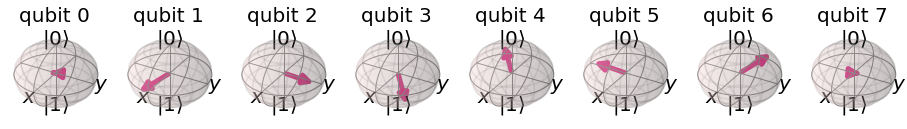

In [4]:
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector


sv = Statevector.from_label('00000000')
mycircuit = QuantumCircuit(8)
for idx, data in enumerate(data_train):

    mycircuit.u3(data[0], data[1], 0, idx)
#     mycircuit.draw('mpl')

#     new_sv = sv.evolve(mycircuit)
#     states.append(new_sv.data)
    
# states = np.array(states)
new_sv = sv.evolve(mycircuit)
plot_bloch_multivector(new_sv.data, figsize=(5,20))

In [110]:
x_train

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [131]:
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

states = []

mapper = {
    '000':'000',
    '011':'001',
    '101':'010',
    '110':'011',
    '001':'100',
    '010':'101',
    '100':'110',
    '111':'111'
    
}

for data in x_train:
    
    b_st = ''.join([str(x) for x in data])
    print(b_st)
    mapped = [int(x) for x in mapper[b_st]]
    data = convert_to_angle(mapped)

    sv = Statevector.from_label('00')

    mycircuit = QuantumCircuit(2)
    mycircuit.u3(data[0], data[1], 0, 1)
    mycircuit.draw('mpl')

    new_sv = sv.evolve(mycircuit)
    states.append(new_sv.data)
    
states = np.array(states)

000
001
010
011
100
101
110
111


In [132]:
num_state = states.shape[-1] 
W = tf.Variable(np.random.random((num_state,num_state)) + np.random.random((num_state,num_state)) * 1j)

EPOCHS = 5000
lamb = 0#1e-1

opt = tf.keras.optimizers.Adam(1e-2)

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

y_train_hinge = 2.0*y_train-1.0

for i in range(EPOCHS):
    with tf.GradientTape() as g:
        tmp1 = tf.eye(num_state, dtype=tf.complex128) - tf.matmul(W, tf.transpose(W, conjugate=True))
        tmp2 = tf.eye(num_state, dtype=tf.complex128) - tf.matmul(tf.transpose(W, conjugate=True), W)
        reg1 = tf.reduce_sum(tmp1 * tf.math.conj(tmp1))
        reg2 = tf.reduce_sum(tmp2 * tf.math.conj(tmp2))
        reg1 = tf.cast(reg1, tf.float32)
        reg2 = tf.cast(reg2, tf.float32)
        evolve_st = tf.transpose(tf.matmul(W, states.T))

        pow2 = tf.cast(tf.math.conj(evolve_st) * evolve_st, tf.float32)
        prob0 = tf.reduce_sum(pow2[:,:num_state//2], axis=1)
        prob1 = tf.reduce_sum(pow2[:,num_state//2:], axis=1) #pow2[:, 1] + pow2[:,2]

        

        tot_prob = prob0 + prob1

        diff = (prob0 - prob1) / (prob0 + prob1)

        h_loss = tf.keras.losses.hinge(y_train_hinge, diff)
        h_acc = hinge_accuracy(y_train_hinge, diff)
    
        loss = h_loss + lamb * (reg1 + reg2)
        
        
    if i % 500 == 0:
        print(f"Loss Epoch {i+1}: hinge loss {h_loss}, reg_loss {reg1 + reg2} acc {h_acc}")
    grads = g.gradient(loss, [W])
    
    opt.apply_gradients(zip(grads, [W]))
    
    
    

Loss Epoch 1: hinge loss 0.8425432443618774, reg_loss 65.28765106201172 acc 0.625
Loss Epoch 501: hinge loss 0.46826308965682983, reg_loss 740.51220703125 acc 1.0
Loss Epoch 1001: hinge loss 0.45060163736343384, reg_loss 2697.27587890625 acc 1.0
Loss Epoch 1501: hinge loss 0.443390816450119, reg_loss 6558.2080078125 acc 1.0
Loss Epoch 2001: hinge loss 0.43938273191452026, reg_loss 12856.677734375 acc 1.0
Loss Epoch 2501: hinge loss 0.43673163652420044, reg_loss 22430.955078125 acc 1.0


KeyboardInterrupt: 

In [136]:
import scipy

def closest_unitary(A):
    """ Calculate the unitary matrix U that is closest with respect to the
        operator norm distance to the general matrix A.

        Return U as a numpy matrix.
    """
    V, __, Wh = scipy.linalg.svd(A)
    U = np.matrix(V.dot(Wh))
    return U

U_closest = closest_unitary(W.numpy())

In [141]:
U_closest, W.numpy()

(matrix([[ 0.42282676-0.06397869j, -0.07548475+0.86321917j,
          -0.09116781+0.0382224j ,  0.21185843+0.10780752j],
         [ 0.62448732-0.62667061j, -0.17282558-0.3789829j ,
           0.02532309-0.00451859j, -0.0445297 +0.20287494j],
         [ 0.01432546-0.03430895j,  0.05066263+0.13101951j,
           0.59794787-0.77104723j, -0.16348239+0.01014279j],
         [ 0.02241495+0.18038579j,  0.07642948-0.22379393j,
           0.17071932-0.09146159j,  0.8831945 +0.30576219j]]),
 array([[ 4.78372735-0.59342529j,  0.05365697+0.97830807j,
         -0.22418969+0.216782j  ,  0.32391815+0.52459494j],
        [ 5.13571463-5.24288198j,  0.50724465+0.49432542j,
         -0.3623997 +0.97069985j,  0.28709669+0.35463796j],
        [-0.40951502+0.22292109j,  0.50819521+0.86720966j,
          5.2493036 -6.704413j  ,  0.38805928+0.00691541j],
        [ 0.07331019+1.09980665j,  0.07046635+0.26479997j,
          1.59853265-1.15115823j,  0.71921273+0.25225725j]]))

In [138]:
tmp1 = tf.eye(num_state, dtype=tf.complex128) - tf.matmul(U_closest, tf.transpose(U_closest, conjugate=True))
tmp2 = tf.eye(num_state, dtype=tf.complex128) - tf.matmul(tf.transpose(U_closest, conjugate=True), W)
reg1 = tf.reduce_sum(tmp1 * tf.math.conj(tmp1))
reg2 = tf.reduce_sum(tmp2 * tf.math.conj(tmp2))
reg1 = tf.cast(reg1, tf.float32)
reg2 = tf.cast(reg2, tf.float32)
evolve_st = tf.transpose(tf.matmul(U_closest, states.T))

pow2 = tf.cast(tf.math.conj(evolve_st) * evolve_st, tf.float32)
prob0 = tf.reduce_sum(pow2[:,:num_state//2], axis=1)
prob1 = tf.reduce_sum(pow2[:,num_state//2:], axis=1) #pow2[:, 1] + pow2[:,2]



tot_prob = prob0 + prob1

diff = (prob0 - prob1) / (prob0 + prob1)

h_loss = tf.keras.losses.hinge(y_train_hinge, diff)
h_acc = hinge_accuracy(y_train_hinge, diff)

In [140]:
h_acc, h_loss

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4485485>)

In [137]:
U_closest

matrix([[ 0.42282676-0.06397869j, -0.07548475+0.86321917j,
         -0.09116781+0.0382224j ,  0.21185843+0.10780752j],
        [ 0.62448732-0.62667061j, -0.17282558-0.3789829j ,
          0.02532309-0.00451859j, -0.0445297 +0.20287494j],
        [ 0.01432546-0.03430895j,  0.05066263+0.13101951j,
          0.59794787-0.77104723j, -0.16348239+0.01014279j],
        [ 0.02241495+0.18038579j,  0.07642948-0.22379393j,
          0.17071932-0.09146159j,  0.8831945 +0.30576219j]])

In [82]:
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

states = []

for data in data_train:

    sv = Statevector.from_label('0000')

    mycircuit = QuantumCircuit(4)
    mycircuit.x(0)
    mycircuit.u3(data[0], data[1], 0, 1)
    mycircuit.u3(data[2], data[3], 0, 2)
    mycircuit.u3(data[4], data[5], 0, 3)
#     mycircuit.draw('mpl')

    new_sv = sv.evolve(mycircuit)
    states.append(new_sv.data)
    
states = np.array(states)

In [83]:
num_state = 16
W = tf.Variable((np.random.random((num_state,num_state)) + np.random.random((num_state,num_state)) * 1j) / (num_state**2))


In [84]:
EPOCHS = 5000
lamb = 0#1e-1

opt = tf.keras.optimizers.Adam(1e-2)

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

y_train_hinge = 2.0*y_train-1.0

for i in range(EPOCHS):
    with tf.GradientTape() as g:
        tmp1 = tf.eye(num_state, dtype=tf.complex128) - tf.matmul(W, tf.transpose(W, conjugate=True))
        tmp2 = tf.eye(num_state, dtype=tf.complex128) - tf.matmul(tf.transpose(W, conjugate=True), W)
        reg1 = tf.reduce_sum(tmp1 * tf.math.conj(tmp1))
        reg2 = tf.reduce_sum(tmp2 * tf.math.conj(tmp2))
        reg1 = tf.cast(reg1, tf.float32)
        reg2 = tf.cast(reg2, tf.float32)
        evolve_st = tf.transpose(tf.matmul(W, states.T))

        pow2 = tf.cast(tf.math.conj(evolve_st) * evolve_st, tf.float32)
        prob0 = tf.reduce_sum(pow2[:,:num_state//2], axis=1)
        prob1 = tf.reduce_sum(pow2[:,num_state//2:], axis=1) #pow2[:, 1] + pow2[:,2]

        

        tot_prob = prob0 + prob1

        diff = (prob0 - prob1) / (prob0 + prob1)

        h_loss = tf.keras.losses.hinge(y_train_hinge, diff)
        h_acc = hinge_accuracy(y_train_hinge, diff)
    
        loss = h_loss + lamb * (reg1 + reg2)
        
        
    if i % 500 == 0:
        print(f"Loss Epoch {i+1}: hinge loss {h_loss}, reg_loss {reg1 + reg2} acc {h_acc}")
    grads = g.gradient(loss, [W])
    
    opt.apply_gradients(zip(grads, [W]))
    
    

Loss Epoch 1: hinge loss 1.0327107906341553, reg_loss 31.989686965942383 acc 0.5
Loss Epoch 501: hinge loss 0.5267128944396973, reg_loss 416.55389404296875 acc 0.75
Loss Epoch 1001: hinge loss 0.5012035369873047, reg_loss 1395.4876708984375 acc 0.875
Loss Epoch 1501: hinge loss 0.49283555150032043, reg_loss 2768.23974609375 acc 0.875
Loss Epoch 2001: hinge loss 0.486368864774704, reg_loss 6238.9140625 acc 0.875
Loss Epoch 2501: hinge loss 0.48191922903060913, reg_loss 19691.375 acc 0.875
Loss Epoch 3001: hinge loss 0.4711693525314331, reg_loss 46975.6328125 acc 0.875
Loss Epoch 3501: hinge loss 0.4468473792076111, reg_loss 113635.5703125 acc 0.875
Loss Epoch 4001: hinge loss 0.4187625050544739, reg_loss 233572.9375 acc 0.875
Loss Epoch 4501: hinge loss 0.40386727452278137, reg_loss 344907.28125 acc 0.875


In [21]:
''.join(x_train[0].astype(str))

'000'

In [104]:
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

states = []

for data in x_train:

    sv = Statevector.from_label('0' + ''.join(data.astype(str)))

    states.append(sv.data)
    
states = np.array(states)

In [105]:
states

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.

In [106]:
W = tf.Variable((np.random.random((16,16)) + np.random.random((16,16)) * 1j)  / (num_state**2) )

In [109]:
EPOCHS = 5000
lamb = 0

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

opt = tf.keras.optimizers.Adam(1e-1)

y_train_hinge = 2.0*y_train-1.0

for i in range(EPOCHS):
    with tf.GradientTape() as g:
        reg1 = tf.reduce_sum((tf.eye(16, dtype=tf.complex128) - tf.matmul(W, tf.transpose(W, conjugate=True))) ** 2)
        reg2 = tf.reduce_sum((tf.eye(16, dtype=tf.complex128) - tf.matmul(tf.transpose(W, conjugate=True), W)) ** 2)
        reg1 = tf.cast(reg1, tf.float32)
        reg2 = tf.cast(reg2, tf.float32)
        evolve_st = tf.transpose(tf.matmul(W, states.T))

        pow2 = tf.cast(tf.math.conj(evolve_st) * evolve_st, tf.float32)
        prob0 = tf.reduce_sum(pow2[:,:8], axis=1)
        prob1 = tf.reduce_sum(pow2[:,8:], axis=1) #pow2[:, 1] + pow2[:,2]

        tot_prob = prob0 + prob1

        diff = (prob0 - prob1) / (prob0 + prob1)

        h_loss = tf.keras.losses.hinge(y_train_hinge, diff)
        h_acc = hinge_accuracy(y_train_hinge, diff)
    
        loss = h_loss + lamb * (reg1 + reg2)
        
        
    if i % 500 == 0:
        print(f"Loss Epoch {i+1}: hinge loss {h_loss}, reg_loss {reg1 + reg2} acc {h_acc}")
    grads = g.gradient(loss, [W])
    
    opt.apply_gradients(zip(grads, [W]))
    
    

Loss Epoch 1: hinge loss 0.9773868322372437, reg_loss -132001.453125 acc 0.625
Loss Epoch 501: hinge loss 0.0791567862033844, reg_loss 1062736896.0 acc 1.0
Loss Epoch 1001: hinge loss 0.0489530935883522, reg_loss 3710291456.0 acc 1.0
Loss Epoch 1501: hinge loss 0.03620630502700806, reg_loss 8504188416.0 acc 1.0
Loss Epoch 2001: hinge loss 0.029051482677459717, reg_loss 15679210496.0 acc 1.0
Loss Epoch 2501: hinge loss 0.024456724524497986, reg_loss 26198441984.0 acc 1.0
Loss Epoch 3001: hinge loss 0.02105681598186493, reg_loss 40990842880.0 acc 1.0
Loss Epoch 3501: hinge loss 0.018498577177524567, reg_loss 61463699456.0 acc 1.0
Loss Epoch 4001: hinge loss 0.01649566739797592, reg_loss 89799884800.0 acc 1.0
Loss Epoch 4501: hinge loss 0.014999374747276306, reg_loss 128674299904.0 acc 1.0


In [653]:
data_train

[[2.186276035465284, -2.356194490192345],
 [2.186276035465284, -0.7853981633974483],
 [2.186276035465284, 2.356194490192345],
 [2.186276035465284, 0.7853981633974483],
 [0.9553166181245092, -2.356194490192345],
 [0.9553166181245092, -0.7853981633974483],
 [0.9553166181245092, 2.356194490192345],
 [0.9553166181245092, 0.7853981633974483]]

In [640]:
data_train

[[2.186276035465284,
  -2.356194490192345,
  2.186276035465284,
  -2.356194490192345],
 [2.186276035465284,
  -0.7853981633974483,
  0.9553166181245092,
  -2.356194490192345],
 [2.186276035465284,
  2.356194490192345,
  2.186276035465284,
  -0.7853981633974483],
 [2.186276035465284,
  0.7853981633974483,
  0.9553166181245092,
  -0.7853981633974483],
 [0.9553166181245092,
  -2.356194490192345,
  2.186276035465284,
  2.356194490192345],
 [0.9553166181245092,
  -0.7853981633974483,
  0.9553166181245092,
  2.356194490192345],
 [0.9553166181245092,
  2.356194490192345,
  2.186276035465284,
  0.7853981633974483],
 [0.9553166181245092,
  0.7853981633974483,
  0.9553166181245092,
  0.7853981633974483]]

In [641]:
def convert_to_circuit(data):
    """Encode truncated classical image into quantum datapoint."""
    values = data
    qubits = cirq.GridQubit.rect(len(data) // 2,1)
    circuit = cirq.Circuit()
    for i in range(len(data) // 2):
        circuit.append(cirq.rx(data[2*i])(qubits[i]))
        circuit.append(cirq.ry(data[2*i+1])(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in data_train]
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)

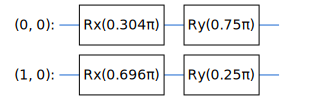

In [642]:
SVGCircuit(x_train_circ[-2])

In [651]:

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(len(data_train[0])//2, 1)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
#     symbol = sympy.Symbol('tmp')
#     circuit.append(cirq.X(readout)**symbol)
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    for i in range(1):
        builder.add_layer(circuit, cirq.XX, f"xx{i}")
#         builder.add_layer(circuit, cirq.YY, f"yy{i}")
#         circuit.append(cirq.CX())
        builder.add_layer(circuit, cirq.ZZ, f"zz{i}")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

# Build the Keras model.

model_circuit, model_readout = create_quantum_model()
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

y_train_hinge = 2.0*y_train-1.0
# y_test_hinge = 2.0*y_test-1.0

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.SGD(1e-4),
    metrics=[hinge_accuracy])

EPOCHS = 100
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1)

# qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 8 samples
Epoch 1/100
8/8 [==============================] - 1s 75ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 1ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 0s 1ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 1ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 0s 1ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 6/100
8/8 [==============================] - 0s 1ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 7/100
8/8 [==============================] - 0s 1ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 8/100
8/8 [==============================] - 0s 1ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 9/100
8/8 [==============================] - 0s 1ms/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 10/100
8/8 [=================

Epoch 78/100
8/8 [==============================] - 0s 780us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 79/100
8/8 [==============================] - 0s 714us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 80/100
8/8 [==============================] - 0s 751us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 81/100
8/8 [==============================] - 0s 688us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 82/100
8/8 [==============================] - 0s 736us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 83/100
8/8 [==============================] - 0s 731us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 84/100
8/8 [==============================] - 0s 714us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 85/100
8/8 [==============================] - 0s 775us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 86/100
8/8 [==============================] - 0s 762us/sample - loss: 1.0000 - hinge_accuracy: 0.5000
Epoch 87/100
8/8 [==========

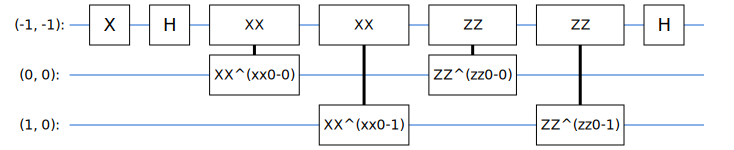

In [648]:
SVGCircuit(model_circuit)

In [649]:
x_train, data_train

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 [[2.186276035465284,
   -2.356194490192345,
   2.186276035465284,
   -2.356194490192345],
  [2.186276035465284,
   -0.7853981633974483,
   0.9553166181245092,
   -2.356194490192345],
  [2.186276035465284,
   2.356194490192345,
   2.186276035465284,
   -0.7853981633974483],
  [2.186276035465284,
   0.7853981633974483,
   0.9553166181245092,
   -0.7853981633974483],
  [0.9553166181245092,
   -2.356194490192345,
   2.186276035465284,
   2.356194490192345],
  [0.9553166181245092,
   -0.7853981633974483,
   0.9553166181245092,
   2.356194490192345],
  [0.9553166181245092,
   2.356194490192345,
   2.186276035465284,
   0.7853981633974483],
  [0.9553166181245092,
   0.7853981633974483,
   0.9553166181245092,
   0.7853981633974483]])

In [650]:
model.layers[-1].set_weights([np.array([1.6,0.7,2,1.4])])

model.predict(x_train_tfcirc_sub), y_train_hinge_sub

(array([[0.3090171 ],
        [0.3090172 ],
        [0.30901718],
        [0.30901706],
        [0.30901715],
        [0.30901715],
        [0.30901715],
        [0.3090171 ]], dtype=float32),
 array([-1., -1., -1., -1.,  1.,  1.,  1.,  1.]))

In [528]:
model.layers[-1].get_weights()

[array([1.0442439], dtype=float32)]

# QRAC VQC convolution 

In [179]:
import itertools
num_bits = 3

x_train = []
y_train = []

for comb in itertools.product('01', repeat=num_bits):
    comb = [int(x) for x in comb]
    x_train.append(comb)
    y_train.append(sum(comb) % 2)
#     y_train.append(int(comb[0]))
    
x_train = np.array(x_train)
y_train = np.array(y_train)

## 2Qbit+ordered encoded

In [180]:
num_qubit = num_bits // 3
x_st = []
for x in x_train:
    x_st.append(''.join(x.astype(str)))
    
x_st = np.array(x_st)

In [181]:
mapper = {
    '000':'000',
    '011':'001',
    '101':'010',
    '110':'011',
    '001':'100',
    '010':'101',
    '100':'110',
    '111':'111'   
}

# q_maps = [mapper, mapper] # 2qbits



In [182]:
y_train

array([0, 1, 1, 0, 1, 0, 0, 1])

In [183]:
from quantum_utils import CustomFeatureMap
from qiskit.aqua.components import variational_forms
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance

import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

seed = 10598

vqc_ordinal_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_ordinal_log.append(loss)

feature_map = CustomFeatureMap('ALL3in1', 1, 1, q_maps)
var_form = variational_forms.RYRZ(num_qubit, depth=4)

training_input = {
    0: x_st[y_train == 0],
    1: x_st[y_train == 1]
}

qsvm = VQC(SPSA(50), feature_map, var_form, training_input, callback=loss_history_callback)

backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


result = qsvm.run(quantum_instance)

y_pred_train = qsvm.predict(x_st)[1]


# F1 score
acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))


# qsvm.save_model(f'models/titanic_QRAC_mapped_no13_implementation_fold_{ro}')


/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:146: DeprecationWarning: The qiskit.aqua.components.feature_

2020-08-13 18:06:00,449:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.2518089463151775
2020-08-13 18:06:01,392:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:06:01,419:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.28558691047757123
2020-08-13 18:06:01,420:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 1: 0.2518089
2020-08-13 18:06:01,420:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 1: 0.2855869
2020-08-13 18:06:02,345:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:06:02,367:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.25602655341037817
2020-08-13 18:06:03,267:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:06:03,292:qiskit.aqua.algorithms.classifiers.vqc:DE

2020-08-13 18:06:22,094:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.2363793
2020-08-13 18:06:22,990:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:06:23,012:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23669478693301832
2020-08-13 18:06:23,909:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:06:23,928:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23632872405701622
2020-08-13 18:06:23,929:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 13: 0.2366948
2020-08-13 18:06:23,929:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 13: 0.2363287
2020-08-13 18:06:24,837:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:06:24,858:qiskit.aqua.algorithms.classi

2020-08-13 18:06:44,466:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23723931949043003
2020-08-13 18:06:44,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 24: 0.2371571
2020-08-13 18:06:44,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 24: 0.2372393
2020-08-13 18:06:45,364:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:06:45,386:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23708316706537608
2020-08-13 18:06:46,264:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:06:46,282:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23715713908070868
2020-08-13 18:06:46,282:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 25: 0.2370832
2020-08-13 18:06:46,283:qiskit.aqua.components.optimi

2020-08-13 18:07:05,964:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23698715849044155
2020-08-13 18:07:06,856:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:07:06,874:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23676445493065104
2020-08-13 18:07:06,874:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 36: 0.2369872
2020-08-13 18:07:06,875:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: 0.2367645
2020-08-13 18:07:07,769:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:07:07,787:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23692041253042045
2020-08-13 18:07:08,727:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:07:08,748:qiskit.aqua.algorithms.classifiers.vqc

2020-08-13 18:07:27,376:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 47: 0.2366512
2020-08-13 18:07:28,255:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:07:28,279:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.23665116163804273
2020-08-13 18:07:29,177:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:07:29,200:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.2366090789007014
2020-08-13 18:07:29,200:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 48: 0.2366512
2020-08-13 18:07:29,200:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 48: 0.2366091
2020-08-13 18:07:30,132:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 18:07:30,162:qiskit.aqua.algorithms.classif

NameError: name 'f1_score' is not defined

In [184]:
np.mean(y_pred_train == y_train)

1.0

In [186]:
x_st + x_st

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')

In [ ]:
### No mapping

from quantum_utils import CustomFeatureMap
from qiskit.aqua.components import variational_forms
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance

import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

seed = 10598

vqc_ordinal_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_ordinal_log.append(loss)

feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit)
var_form = variational_forms.RYRZ(num_qubit, depth=4)

training_input = {
    0: x_st[y_train == 0],
    1: x_st[y_train == 1]
}

qsvm = VQC(SPSA(50), feature_map, var_form, training_input, callback=loss_history_callback)

backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


result = qsvm.run(quantum_instance)

y_pred_train = qsvm.predict(x_st)[1]


# F1 score
# acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))


# qsvm.save_model(f'models/titanic_QRAC_mapped_no13_implementation_fold_{ro}')

np.mean(y_pred_train == y_train)


# Conv

In [169]:
num_qubit = 4
x_st = []
for x in x_train:
    st = ''
    for i in range(4):
        st += ''.join(x[i:i+3].astype(str))
    x_st.append(st)
    
x_st = np.array(x_st)

In [170]:
x_st

array(['000000000000', '000000000001', '000000001010', '000000001011',
       '000001010100', '000001010101', '000001011110', '000001011111',
       '001010100000', '001010100001', '001010101010', '001010101011',
       '001011110100', '001011110101', '001011111110', '001011111111',
       '010100000000', '010100000001', '010100001010', '010100001011',
       '010101010100', '010101010101', '010101011110', '010101011111',
       '011110100000', '011110100001', '011110101010', '011110101011',
       '011111110100', '011111110101', '011111111110', '011111111111',
       '100000000000', '100000000001', '100000001010', '100000001011',
       '100001010100', '100001010101', '100001011110', '100001011111',
       '101010100000', '101010100001', '101010101010', '101010101011',
       '101011110100', '101011110101', '101011111110', '101011111111',
       '110100000000', '110100000001', '110100001010', '110100001011',
       '110101010100', '110101010101', '110101011110', '110101011111',
      

In [173]:
### No mapping

from quantum_utils import CustomFeatureMap
from qiskit.aqua.components import variational_forms
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance

import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

seed = 10598

vqc_ordinal_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_ordinal_log.append(loss)

feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit)
var_form = variational_forms.RYRZ(num_qubit, depth=4)

training_input = {
    0: x_st[y_train == 0],
    1: x_st[y_train == 1]
}

qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


result = qsvm.run(quantum_instance)

y_pred_train = qsvm.predict(x_st)[1]


# F1 score
# acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))


# qsvm.save_model(f'models/titanic_QRAC_mapped_no13_implementation_fold_{ro}')

np.mean(y_pred_train == y_train)


/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:146: DeprecationWarning: The qiskit.aqua.components.feature_

2020-08-13 14:59:40,262:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7194208883087323
2020-08-13 14:59:43,073:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 14:59:43,347:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7279836971835985
2020-08-13 14:59:46,270:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 14:59:46,589:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7168085092726166
2020-08-13 14:59:49,611:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 14:59:49,948:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7169297062186808
2020-08-13 14:59:52,867:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 14:59:53,191:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-08-13 15:01:41,198:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:01:41,474:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7264737895778277
2020-08-13 15:01:44,516:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:01:44,791:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7298432126534175
2020-08-13 15:01:44,792:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.7264738
2020-08-13 15:01:44,792:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.7298432
2020-08-13 15:01:47,714:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:01:48,009:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.749351103088345
2020-08-13 15:01:50,922:qiskit.aqua.utils.run_circuits:INFO: Can't s

2020-08-13 15:03:06,596:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.7210390
2020-08-13 15:03:06,597:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 0.7211592
2020-08-13 15:03:09,526:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:03:09,783:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7157425802010813
2020-08-13 15:03:12,773:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:03:13,077:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7280262786050222
2020-08-13 15:03:13,078:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.7157426
2020-08-13 15:03:13,079:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.7280263
2020-08-13 15:03:16,142:qiskit.aqua.utils.run_

2020-08-13 15:04:28,610:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:04:28,935:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.711196113153458
2020-08-13 15:04:28,935:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 23: 0.7090808
2020-08-13 15:04:28,936:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 23: 0.7111961
2020-08-13 15:04:31,882:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:04:32,151:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7118283570852568
2020-08-13 15:04:35,086:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:04:35,355:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7094625117761546
2020-08-13 15:04:35,356:qiskit.aqua.components.optimizers.spsa:DEB

2020-08-13 15:05:48,192:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:05:48,519:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7027167962949452
2020-08-13 15:05:51,541:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:05:51,847:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.70593152707881
2020-08-13 15:05:51,848:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 35: 0.7027168
2020-08-13 15:05:51,849:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.7059315
2020-08-13 15:05:54,881:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:05:55,170:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7028010857026086
2020-08-13 15:06:02,474:qiskit.aqua.utils.run_circuits:INFO: Can't 

2020-08-13 15:07:08,408:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.7018293
2020-08-13 15:07:08,408:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 0.7043320
2020-08-13 15:07:11,477:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:07:11,771:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6995072816578046
2020-08-13 15:07:14,762:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:07:15,024:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6993075397457644
2020-08-13 15:07:15,025:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 47: 0.6995073
2020-08-13 15:07:15,025:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 47: 0.6993075
2020-08-13 15:07:22,586:qiskit.aqua.utils.run_

2020-08-13 15:08:31,245:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:08:31,532:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.704698698252995
2020-08-13 15:08:31,533:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: 0.7051418
2020-08-13 15:08:31,534:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: 0.7046987
2020-08-13 15:08:34,512:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:08:34,784:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6993767265466242
2020-08-13 15:08:42,723:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:08:43,018:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.704950346141236
2020-08-13 15:08:43,019:qiskit.aqua.components.optimizers.spsa:DEBU

2020-08-13 15:09:52,793:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:09:53,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7019260688488723
2020-08-13 15:09:56,131:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:09:56,439:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7000649692149652
2020-08-13 15:09:56,440:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.7019261
2020-08-13 15:09:56,441:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.7000650
2020-08-13 15:09:59,376:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:09:59,649:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7017642977907895
2020-08-13 15:10:02,707:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-13 15:11:14,653:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.7053318
2020-08-13 15:11:14,654:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 81: 0.7023384
2020-08-13 15:11:17,712:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:11:18,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6973038913679993
2020-08-13 15:11:21,072:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:11:21,382:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7043819547946817
2020-08-13 15:11:21,383:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 82: 0.6973039
2020-08-13 15:11:21,383:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 82: 0.7043820
2020-08-13 15:11:24,542:qiskit.aqua.utils.run_

2020-08-13 15:12:40,119:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:12:40,377:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6965209980114586
2020-08-13 15:12:40,377:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: 0.6954106
2020-08-13 15:12:40,378:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: 0.6965210
2020-08-13 15:12:43,348:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:12:43,669:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6993726521506064
2020-08-13 15:12:46,738:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:12:47,008:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7020493215404056
2020-08-13 15:12:47,009:qiskit.aqua.components.optimizers.spsa:DE

2020-08-13 15:14:02,624:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:14:02,889:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6930497976449816
2020-08-13 15:14:05,915:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:14:06,189:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7020706446490159
2020-08-13 15:14:06,189:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 105: 0.6930498
2020-08-13 15:14:06,190:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: 0.7020706
2020-08-13 15:14:09,195:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:14:09,507:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6941159847495892
2020-08-13 15:14:12,564:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-13 15:15:25,807:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 116: 0.6992849
2020-08-13 15:15:25,808:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 116: 0.6895843
2020-08-13 15:15:28,882:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:15:29,160:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6983743831489828
2020-08-13 15:15:32,293:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:15:32,549:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6997224689588672
2020-08-13 15:15:32,550:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 117: 0.6983744
2020-08-13 15:15:32,551:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 117: 0.6997225
2020-08-13 15:15:35,741:qiskit.aqua.utils.

2020-08-13 15:16:56,941:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:16:57,196:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6936188117278186
2020-08-13 15:16:57,196:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: 0.6962726
2020-08-13 15:16:57,197:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: 0.6936188
2020-08-13 15:17:00,318:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:17:00,651:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6940801694007059
2020-08-13 15:17:03,778:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:17:04,040:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6955663963006863
2020-08-13 15:17:04,041:qiskit.aqua.components.optimizers.spsa:

2020-08-13 15:18:14,778:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:18:15,087:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6989510884179267
2020-08-13 15:18:24,080:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:18:24,372:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.69669273022515
2020-08-13 15:18:24,373:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 140: 0.6989511
2020-08-13 15:18:24,373:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 140: 0.6966927
2020-08-13 15:18:27,545:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:18:27,864:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6940183020989943
2020-08-13 15:18:31,011:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-13 15:19:39,001:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 151: 0.6932006
2020-08-13 15:19:39,001:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 151: 0.6947206
2020-08-13 15:19:42,125:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:19:42,421:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.696893082200619
2020-08-13 15:19:45,516:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:19:45,846:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6941795298411412
2020-08-13 15:19:45,847:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 152: 0.6968931
2020-08-13 15:19:45,848:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 152: 0.6941795
2020-08-13 15:19:48,930:qiskit.aqua.utils.r

2020-08-13 15:21:06,215:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:21:06,491:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6985852729944041
2020-08-13 15:21:06,492:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: 0.6943631
2020-08-13 15:21:06,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: 0.6985853
2020-08-13 15:21:09,620:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:21:09,907:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6945913329727194
2020-08-13 15:21:12,992:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:21:13,265:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6930864689946832
2020-08-13 15:21:13,266:qiskit.aqua.components.optimizers.spsa:

2020-08-13 15:22:30,720:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:22:30,980:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6966101710181023
2020-08-13 15:22:34,130:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:22:34,440:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6928742886127939
2020-08-13 15:22:34,440:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 175: 0.6966102
2020-08-13 15:22:34,441:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 175: 0.6928743
2020-08-13 15:22:37,467:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:22:37,715:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6909598966833934
2020-08-13 15:22:40,778:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-13 15:23:49,392:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 186: 0.6972425
2020-08-13 15:23:49,393:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 186: 0.6959577
2020-08-13 15:23:52,444:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:23:52,775:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6936549752115952
2020-08-13 15:24:12,311:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:24:12,627:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6912574501354243
2020-08-13 15:24:12,628:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 187: 0.6936550
2020-08-13 15:24:12,629:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 187: 0.6912575
2020-08-13 15:24:15,857:qiskit.aqua.utils.

2020-08-13 15:25:28,017:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:25:28,325:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6912519271877428
2020-08-13 15:25:28,326:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 198: 0.6935220
2020-08-13 15:25:28,327:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 198: 0.6912519
2020-08-13 15:25:31,472:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:25:31,776:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6955885543928373
2020-08-13 15:25:34,956:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:25:35,271:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6957527500911489
2020-08-13 15:25:35,272:qiskit.aqua.components.optimizers.spsa:

0.5

# Repeat

In [ ]:
num_qubit = 4
x_st = []
for x in x_train:
    st = ''
    for i in [0]:
        st += ''.join(x[i:i+3].astype(str)) * 2
    x_st.append(st)
    
x_st = np.array(x_st)

In [177]:
x_st

array(['000000000000', '000000001001', '000000010010', '000000011011',
       '000000100100', '000000101101', '000000110110', '000000111111',
       '001001000000', '001001001001', '001001010010', '001001011011',
       '001001100100', '001001101101', '001001110110', '001001111111',
       '010010000000', '010010001001', '010010010010', '010010011011',
       '010010100100', '010010101101', '010010110110', '010010111111',
       '011011000000', '011011001001', '011011010010', '011011011011',
       '011011100100', '011011101101', '011011110110', '011011111111',
       '100100000000', '100100001001', '100100010010', '100100011011',
       '100100100100', '100100101101', '100100110110', '100100111111',
       '101101000000', '101101001001', '101101010010', '101101011011',
       '101101100100', '101101101101', '101101110110', '101101111111',
       '110110000000', '110110001001', '110110010010', '110110011011',
       '110110100100', '110110101101', '110110110110', '110110111111',
      

In [178]:
### No mapping

from quantum_utils import CustomFeatureMap
from qiskit.aqua.components import variational_forms
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance

import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

seed = 10598

vqc_ordinal_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_ordinal_log.append(loss)

feature_map = CustomFeatureMap('ALL3in1', 1, num_qubit)
var_form = variational_forms.RYRZ(num_qubit, depth=4)

training_input = {
    0: x_st[y_train == 0],
    1: x_st[y_train == 1]
}

qsvm = VQC(SPSA(200), feature_map, var_form, training_input, callback=loss_history_callback)

backend_options = {"method": "statevector_gpu"}
backend = QasmSimulator(backend_options)

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


result = qsvm.run(quantum_instance)

y_pred_train = qsvm.predict(x_st)[1]


# F1 score
# acc_f1_train = (np.mean(y_pred_train == y_train), f1_score(y_train, y_pred_train))


# qsvm.save_model(f'models/titanic_QRAC_mapped_no13_implementation_fold_{ro}')

np.mean(y_pred_train == y_train)


/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
            The <class 'quantum_utils.CustomFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
/home/hpc/anaconda3/envs/tf-quantum/lib/python3.7/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:146: DeprecationWarning: The qiskit.aqua.components.feature_

2020-08-13 15:31:46,304:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7393694295972524
2020-08-13 15:31:49,543:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:31:49,802:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7373098396114013
2020-08-13 15:31:52,896:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:31:53,172:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7380990325297925
2020-08-13 15:31:56,222:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:31:56,498:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7203905807439169
2020-08-13 15:31:59,732:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:32:00,014:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate b

2020-08-13 15:34:03,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:34:03,709:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7359759898818439
2020-08-13 15:34:06,960:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:34:07,213:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7369504454072056
2020-08-13 15:34:07,213:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.7359760
2020-08-13 15:34:07,213:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.7369504
2020-08-13 15:34:10,388:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:34:10,667:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7409999308388571
2020-08-13 15:34:13,916:qiskit.aqua.utils.run_circuits:INFO: Can't 

2020-08-13 15:35:23,561:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.7084492
2020-08-13 15:35:23,562:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 0.7039307
2020-08-13 15:35:26,796:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:35:27,049:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7039461857637639
2020-08-13 15:35:30,258:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:35:30,546:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7156336309963791
2020-08-13 15:35:30,547:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.7039462
2020-08-13 15:35:30,548:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.7156336
2020-08-13 15:35:33,812:qiskit.aqua.utils.run_

2020-08-13 15:36:54,074:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:36:54,386:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7139160533915909
2020-08-13 15:36:54,388:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 23: 0.7090060
2020-08-13 15:36:54,388:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 23: 0.7139161
2020-08-13 15:36:57,640:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:36:57,902:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7085100025269667
2020-08-13 15:37:01,069:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:37:01,363:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7116282716736504
2020-08-13 15:37:01,364:qiskit.aqua.components.optimizers.spsa:DE

2020-08-13 15:38:33,589:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:38:33,871:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7107537663185588
2020-08-13 15:38:37,021:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:38:37,301:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7030973723088407
2020-08-13 15:38:37,302:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 35: 0.7107538
2020-08-13 15:38:37,302:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.7030974
2020-08-13 15:38:40,535:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:38:40,826:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7070645695636681
2020-08-13 15:38:44,176:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-13 15:39:54,354:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.7066909
2020-08-13 15:39:54,355:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 0.7052420
2020-08-13 15:39:57,611:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:39:57,886:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6969558484157243
2020-08-13 15:40:01,194:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:40:01,465:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7040062227583392
2020-08-13 15:40:01,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 47: 0.6969558
2020-08-13 15:40:01,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 47: 0.7040062
2020-08-13 15:40:04,709:qiskit.aqua.utils.run_

2020-08-13 15:41:35,074:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:41:35,355:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.701201721937379
2020-08-13 15:41:35,356:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 58: 0.6954815
2020-08-13 15:41:35,357:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 58: 0.7012017
2020-08-13 15:41:38,660:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:41:38,946:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6972143061096732
2020-08-13 15:41:42,072:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:41:42,331:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7056054467127187
2020-08-13 15:41:42,332:qiskit.aqua.components.optimizers.spsa:DEB

2020-08-13 15:42:55,575:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:42:55,896:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7007599525108978
2020-08-13 15:42:59,165:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:42:59,465:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6978625641276515
2020-08-13 15:42:59,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.7007600
2020-08-13 15:42:59,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.6978626
2020-08-13 15:43:02,878:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:43:03,146:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6990400754729322
2020-08-13 15:43:06,405:qiskit.aqua.utils.run_circuits:INFO: Can'

2020-08-13 15:44:26,153:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.7015600
2020-08-13 15:44:26,153:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 81: 0.6948431
2020-08-13 15:44:29,392:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:44:29,720:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6987573589926592
2020-08-13 15:44:33,046:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:44:33,323:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.692719554895978
2020-08-13 15:44:33,324:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 82: 0.6987574
2020-08-13 15:44:33,324:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 82: 0.6927196
2020-08-13 15:44:36,680:qiskit.aqua.utils.run_c

2020-08-13 15:45:51,428:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:45:51,699:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7025789534561755
2020-08-13 15:45:51,699:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: 0.6968547
2020-08-13 15:45:51,700:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: 0.7025790
2020-08-13 15:46:03,447:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:46:03,724:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6937336431085037
2020-08-13 15:46:06,945:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:46:07,229:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6948757535491579
2020-08-13 15:46:07,230:qiskit.aqua.components.optimizers.spsa:DE

2020-08-13 15:47:22,480:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:47:22,765:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6920616500104726
2020-08-13 15:47:26,036:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:47:26,318:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6894440507078997
2020-08-13 15:47:26,319:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 105: 0.6920617
2020-08-13 15:47:26,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 105: 0.6894441
2020-08-13 15:47:29,704:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:47:29,991:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6954601138686876
2020-08-13 15:47:33,321:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-13 15:48:54,584:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 116: 0.6936051
2020-08-13 15:48:54,584:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 116: 0.6925940
2020-08-13 15:48:58,007:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:48:58,298:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6980081756909208
2020-08-13 15:49:01,617:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:49:01,880:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6952945849451493
2020-08-13 15:49:01,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 117: 0.6980082
2020-08-13 15:49:01,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 117: 0.6952946
2020-08-13 15:49:05,155:qiskit.aqua.utils.

2020-08-13 15:50:20,453:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:50:20,708:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6938852189542275
2020-08-13 15:50:20,709:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 128: 0.6959537
2020-08-13 15:50:20,709:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 128: 0.6938852
2020-08-13 15:50:24,048:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:50:24,349:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6951378979335792
2020-08-13 15:50:27,670:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:50:27,956:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6942368749111502
2020-08-13 15:50:27,957:qiskit.aqua.components.optimizers.spsa:

2020-08-13 15:51:52,361:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:51:52,632:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6936076248575669
2020-08-13 15:51:55,899:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:51:56,158:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6941774227323985
2020-08-13 15:51:56,158:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 140: 0.6936076
2020-08-13 15:51:56,159:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 140: 0.6941774
2020-08-13 15:51:59,455:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:51:59,733:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6955953110110518
2020-08-13 15:52:03,133:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-13 15:53:16,183:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 151: 0.6904860
2020-08-13 15:53:16,184:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 151: 0.6912420
2020-08-13 15:53:19,433:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:53:19,693:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6819939447076603
2020-08-13 15:53:23,007:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:53:23,262:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6922486818886355
2020-08-13 15:53:23,263:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 152: 0.6819939
2020-08-13 15:53:23,263:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 152: 0.6922487
2020-08-13 15:53:26,643:qiskit.aqua.utils.

2020-08-13 15:54:52,703:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:54:52,986:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6890386116362067
2020-08-13 15:54:52,987:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: 0.6975587
2020-08-13 15:54:52,988:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: 0.6890386
2020-08-13 15:54:56,350:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:54:56,610:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.687324455459933
2020-08-13 15:54:59,928:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:55:00,207:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6847798132044695
2020-08-13 15:55:00,208:qiskit.aqua.components.optimizers.spsa:D

2020-08-13 15:56:16,054:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:56:16,319:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6862857663347801
2020-08-13 15:56:19,634:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:56:19,890:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6844620902435459
2020-08-13 15:56:19,891:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 175: 0.6862858
2020-08-13 15:56:19,892:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 175: 0.6844621
2020-08-13 15:56:23,335:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:56:23,610:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6900243592258257
2020-08-13 15:56:26,975:qiskit.aqua.utils.run_circuits:INFO: Ca

2020-08-13 15:57:49,757:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 186: 0.6946339
2020-08-13 15:57:49,757:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 186: 0.6901010
2020-08-13 15:57:52,970:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:57:53,234:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6864142904311312
2020-08-13 15:57:56,634:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:57:56,955:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6933412049069431
2020-08-13 15:57:56,956:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 187: 0.6864143
2020-08-13 15:57:56,957:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 187: 0.6933412
2020-08-13 15:58:00,417:qiskit.aqua.utils.

2020-08-13 15:59:17,675:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:59:17,981:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6841583482328595
2020-08-13 15:59:17,982:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 198: 0.6876888
2020-08-13 15:59:17,983:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 198: 0.6841583
2020-08-13 15:59:21,393:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:59:21,649:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6924642206976093
2020-08-13 15:59:25,065:qiskit.aqua.utils.run_circuits:INFO: Can't skip qobj validation for the NoneType provider.
2020-08-13 15:59:25,365:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6912918717529934
2020-08-13 15:59:25,366:qiskit.aqua.components.optimizers.spsa:

0.5

In [237]:
!ls results

16px_11520_10_111_history.pk
16px_11520_10_222_history.pk
16px_11520_10_333_history.pk
16px_11520_10_444_history.pk
16px_11520_10_555_history.pk
16px_11520_5_2_111_history.pk
16px_11520_5_2_222_history.pk
16px_11520_5_2_333_history.pk
16px_11520_5_2_444_history.pk
16px_11520_5_2_555_history.pk
16px_11520_5_training.pk
8px_11520_10_1_111_history.pk
8px_11520_10_1_222_history.pk
8px_11520_10_1_333_history.pk
8px_11520_10_1_444_history.pk
8px_11520_10_1_555_history.pk
8px_11520_5_2_111_history.pk
8px_11520_5_2_222_history.pk
8px_11520_5_2_333_history.pk
8px_11520_5_2_444_history.pk
8px_11520_5_2_555_history.pk
bc_ordinal_record.pk
bc_qrac_mapped_record.pk
bc_qrac_record.pk
conv_all_11520_10_111_history.pk
conv_all_11520_10_222_history.pk
conv_all_11520_10_333_history.pk
conv_all_11520_10_444_history.pk
conv_all_11520_10_555_history.pk
conv_all_11520_5_2_111_history.pk
conv_all_11520_5_2_222_history.pk
conv_all_11520_5_2_333_history.pk
conv_all_11520_5_2_444_history.pk
conv_all_11520_5_2_5

In [243]:
import pickle
import glob

bits = [3,6,9]
results = []

for bit in bits:
    with open(f'results/Parity_check_qrac_map_{bit}_1', 'rb') as f:
        results.append(pickle.load(f))

0.5
0.25
1.0
0.875
1.0


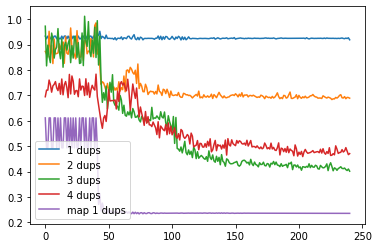

In [247]:
import pickle
import glob

bit = 3
dups = [1,2,3,4]
results = []

for dup in dups:
    with open(f'results/Parity_check_qrac_{bit}_{dup}', 'rb') as f:
        result = pickle.load(f)
        print(result[-1])
        plt.plot(result[0], label=f"{dup} dups")

with open(f'results/Parity_check_qrac_map_{bit}_1', 'rb') as f:
    result = pickle.load(f)
print(result[-1])
plt.plot(result[0], label=f"map 1 dups")

plt.legend()

0.53125
0.453125
0.53125
1.0


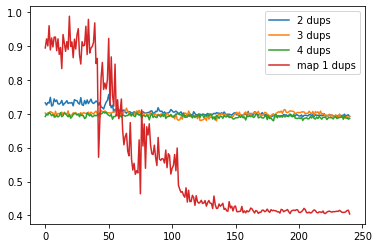

In [248]:
import pickle
import glob

bit = 6
dups = [2,3,4]
results = []

for dup in dups:
    with open(f'results/Parity_check_qrac_{bit}_{dup}', 'rb') as f:
        result = pickle.load(f)
        print(result[-1])
        plt.plot(result[0], label=f"{dup} dups")

with open(f'results/Parity_check_qrac_map_{bit}_1', 'rb') as f:
    result = pickle.load(f)
print(result[-1])
plt.plot(result[0], label=f"map 1 dups")

plt.legend()

0.53125
0.578125


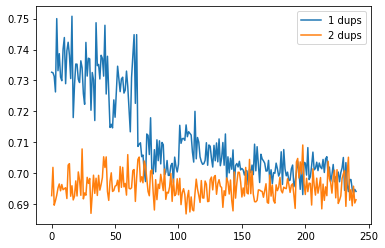

In [249]:
import pickle
import glob

bit = 6
dups = [1,2]
results = []

for dup in dups:
    with open(f'results/Parity_check_conv_{bit}_{dup}', 'rb') as f:
        result = pickle.load(f)
        print(result[-1])
        plt.plot(result[0], label=f"{dup} dups")
        
plt.legend()

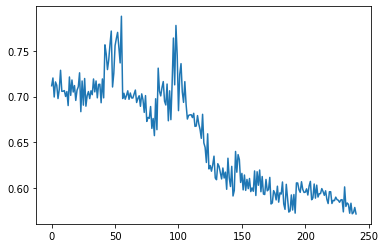

In [250]:
m = 'results/Parity_check_qrac_map_9_1'
with open(m, 'rb') as f:
    result = pickle.load(f)
plt.plot(result[0])

In [251]:
print(result[1])

0.7578125
